In [1]:
using Gen
using Random
using Distributions
using StatsBase: mean, std, quantile
using BenchmarkTools
using FilePathsBase;
using LinearAlgebra: dot, Diagonal
using JSON
import PyPlot
plt = PyPlot.plt
using JLD

display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [3]:
include("utils.jl")
include("environment.jl")
include("raycaster.jl")
include("plotting.jl")
include("code_from_part_1.jl");

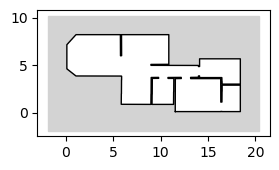

(187, 4)


In [4]:
env = load_env(2010)
println(size(env.segs))
plt.figure(figsize=(3,3)); plt.gca().set_aspect(1.);
draw_env!(env);

# Utilities

In [5]:
"""
    is_valid_move(x, y, env::Env)

Checks if the step from `x` to `y` passes through an 
obstacle, and if so returns a scalar `s`  such that 
`(1-s)*x + s*y` encodes the intersection with the boundary
"""
function is_valid_move(x, y, env::Env)
    v = y - x
    _,C,S,T = ray_coll([x;y], env.segs) 
    if sum(C) == 0
        return true, nothing
    else
        s = min(S[C]...)
        return s > 1., s
    end
end;

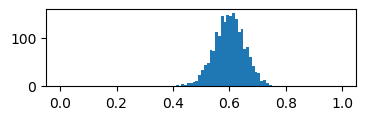

0.6002555453945297

In [6]:
"Beta-like distribution over a bigger interval."
@dist function my_scaled_beta(a, mean, scale)
    mean_beta = mean/scale
    b = a/mean_beta - a
    scale*beta(a,b);
end;

a = 50.
mean_speed = .6
max_speed = 1.

samples = [my_scaled_beta(a, mean_speed, max_speed) for t=1:2000]
plt.figure(figsize=(4,1));
plt.hist(samples, bins=0:max_speed/100:max_speed);
mean(samples)

# Controller- and Transition Model

In [7]:
"""
    Control

Contains the controls of the agent. 
"""
struct Control <: StructIterator
    "speed"
    s::Float64 
    "change of head direction"
    dhd::Float64
end;


"""
    control_prior(pose, z, env, mean_speed, max_speed, dhd_noise)

Ignores `pose`, `z`, `env` and mindlessly samples a random control vector.
"""
@gen function control_prior(pose::Pose, z, env::Env, mean_speed, max_speed, dhd_noise)
    s   ~ my_scaled_beta(50., mean_speed, max_speed)
    dhd ~ normal(0, dhd_noise)
    return Control(s, dhd)
end;

In [8]:
"""
    ghost_transition_model(pose::Pose, u::Control, env::Env, hd_noise, x_noise) 

A motion model for an agent that does **not** respect environmental boundaries.
"""
@gen function ghost_transition_model(pose::Pose, u::Control, env::Env, hd_noise, x_noise)    
    hd ~ normal(pose.hd + u.dhd, hd_noise) 
    v = [u.s*cos(hd); u.s*sin(hd)]
    x ~ mvnormal(pose.x + v, Diagonal([x_noise, x_noise]))
    return Pose(x, hd)
end;

# Model w/o Mapping 

In [11]:
"""
    SLAMState

Kernel-state composed of 
- current pose, 
- measurement made at the current pose, and 
- control which will be applied to the current pose.
"""
mutable struct SLAMState <: StructIterator
    pose::Pose 
    z::Array{Float64} 
    u::Control
end


@gen function slam_kernel(t::Int, 
                          bel::SLAMState, 
                          env::Env, 
                          control_model::DynamicDSLFunction,
                          control_args,
                          transition_model::DynamicDSLFunction,
                          transition_args,
                          sensor_model::DynamicDSLFunction,
                          sensor_args)
    
    pose  = @trace(transition_model(bel.pose, bel.u, env, transition_args...), :pose)
    
#     if validate_move
#         valid, = is_valid_move(bel.pose.x, pose.x, env)
#         @trace(bernoulli(valid), :valid)    
#         if !valid
#            pose = bel.pose 
#         end
#     end
    
    z     = @trace(sensor_model(pose, env, sensor_args...), :sense)
    u     = @trace(control_model(pose, z, env, control_args...), :u)
    
    return SLAMState(pose, z, u)
end

slam_chain = Gen.Unfold(slam_kernel);

Let us first look at a simple trace (with `num_rays` and `T` small) and define some helper to access the data.

In [12]:
# Config
# ---
control_args = (mean_speed=1., max_speed=2., dhd_noise=0.1)
sensor_args  = (num_rays=3, fov=180, angular_noise=0.1, depth_noise=0.1, max_depth=20.)
transition_args = (hd_noise=0.01, x_noise=0.01)

# Initial state of the chain
# ---
pose0  = Pose([2.5; 9.], -0.1)
z0     = sensor_model(pose0, env, sensor_args...)
u0     = Control(1.0, 0.0)
bel0   = SLAMState(pose0, z0, u0)

T = 2

slam_args =  (T, bel0, env, 
    control_prior, control_args, 
    ghost_transition_model, 
    transition_args, 
    sensor_model, sensor_args)

tr = Gen.simulate(slam_chain, slam_args,);
ch = get_choices(tr)

│
├── 1
│   │
│   ├── :pose
│   │   │
│   │   ├── :hd : -0.0949785537930484
│   │   │
│   │   └── :x : [3.4428192619373994, 8.83319698713838]
│   │
│   ├── :sense
│   │   │
│   │   ├── :z : [18.17512459425348, 3.6757669368978596, 22.22629096629553]
│   │   │
│   │   └── :ray_directions : [-3.2848301068979637, -0.10672163989639569, 3.105073571650313]
│   │
│   └── :u
│       │
│       ├── :s : 1.112749025076085
│       │
│       └── :dhd : -0.022035014019580506
│
└── 2
    │
    ├── :pose
    │   │
    │   ├── :hd : -0.11245741908893908
    │   │
    │   └── :x : [4.534229827305163, 8.796747097085596]
    │
    ├── :sense
    │   │
    │   ├── :z : [18.250347821425727, 4.672433613632803, 20.94895517880245]
    │   │
    │   └── :ray_directions : [-3.303190275685343, -0.12014052763461089, 3.0402309126838545]
    │
    └── :u
        │
        ├── :s : 1.0146901635537935
        │
        └── :dhd : 0.09415814850275986


In [13]:
function get_poses_and_controls(tr)
    T, bel0, = get_args(tr)
    ch = get_choices(tr)
    p  = Array{Pose,1}(undef, T)
    u  = Array{Control,1}(undef, T)
    z  = zeros(T, size(bel0.z)...)

    
    for t=1:T
        p[t] = Pose(tr[t => :pose => :x], tr[t => :pose => :hd])
        u[t] = Control(tr[t => :u => :s], tr[t => :u => :dhd])
        z[t,:] = tr[t => :sense => :z]
    end
    return p, u, z
end

get_xs_from_poses(ps) = hcat(map(p -> getfield(p, :x), ps)...)'

get_xs_from_poses (generic function with 1 method)

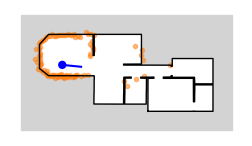

In [14]:
# Config
# ---
control_args = (mean_speed=.6, max_speed=1., dhd_noise=0.1)
sensor_args  = (num_rays=100, fov=180, angular_noise=1e-2, depth_noise=1e-2, max_depth=20.)
transition_args = (hd_noise=0.01, x_noise=0.01)

# Initial state of the chain
# ---
pose0  = Pose([2.5; 5.], -0.1)
z0     = sensor_model(pose0, env, sensor_args...)
u0     = Control(1.0, 0.0)
bel0   = SLAMState(pose0, z0, u0)

####
plt.figure(figsize=(3,3)); plt.gca().set_aspect(1.); plt.gca().axis("off")
draw_env!(env)
draw_pose!(pose0...; len=2., c="b", zorder=4)
draw_sense!(pose0..., z0, sensor_args; c="C1", alpha=.5);

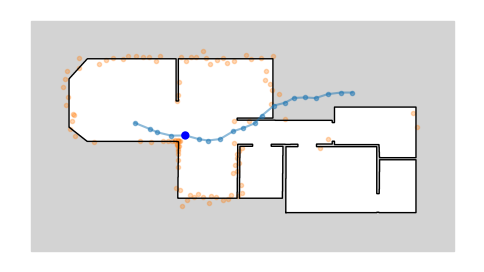

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f8b0e92d9d0>

In [17]:
T = 20

slam_args =  (T, bel0, env, 
    control_prior, control_args, 
    ghost_transition_model, 
    transition_args, 
    sensor_model, sensor_args)

tr = Gen.simulate(slam_chain, slam_args,);

####

ps, us, zs = get_poses_and_controls(tr)
xs = get_xs_from_poses(ps);
t  = 5

####
plt.figure(figsize=(6,6)); plt.gca().set_aspect(1.); plt.gca().axis("off")
draw_env!(env)
draw_pose!(ps[t]...; len=0.0, c="b", zorder=4)
draw_sense!(ps[t]..., zs[t,:], sensor_args; c="C1", alpha=.3);
plt.plot(xs[:,1], xs[:,2], marker=".", alpha=0.5, c="C0", zorder=1)


# Path planning

In [ ]:
# using Pkg
# Pkg.add(PackageSpec(url="https://github.com/probcomp/Gen2DAgentMotion.jl"))

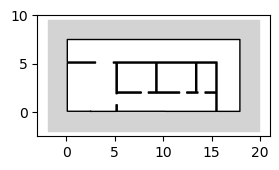

(77, 4)


In [725]:
env = load_env(32371)
println(size(env.segs))
plt.figure(figsize=(3,3)); plt.gca().set_aspect(1.);
draw_env!(env);

In [44]:
import Gen2DAgentMotion: plan_path, refine_path, Path, Scene, 
    Bounds, Wall, Point, PlannerParams, RRTTree, simplify_path, plan_and_optimize_path

Scene(env::Env) = Scene(Bounds(env.bounds'...),[Wall(Point(s[1:2]...),Point(s[3:4]...)) for s in eachrow(env.segs)] )

is_inside(p::Pose, env::Env) = is_inside(p.x, env.segs)

function decompose(path::Array{Point,1})
    x   = vcat([[p.x p.y] for p in path]...)
    dx  = x[2:end,:] - x[1:end-1,:]
    hd  = [atan(v[2],v[1]) for v in eachrow(dx)]
    s   = sum(dx.^2, dims=2)[:,1]
    dhd = (hd[2:end] - hd[1:end-1]).%2π    
    return x, hd, s, dhd 
end

decompose(path::Path) = decompose(path.points)


function pose_and_control(path::Path)
    x, hd, s, dhd = decompose(path)
    T = size(dhd,1)
    
    u = [Control(s[t],dhd[t]) for t=1:T]
    p = [Pose(x[t], hd[t]) for t=1:T+1]
end


function random_pose_inside(env)
    while true
        p = pose_prior(env)
        if is_inside(p, env)
            return p
        end
    end
end

function draw_tree!(tree::RRTTree; ax=plt.gca(), c="black",zorder=nothing, alpha=0.5)
    for node in 1:tree.num_nodes
        a = Point(tree.confs[1,node], tree.confs[2,node])
        parent = tree.parents[node]
        if parent == 0
            continue
        end
        b = Point(tree.confs[1,parent],tree.confs[2,parent])
        ax.plot([a.x, b.x], [a.y, b.y], color=c, zorder=zorder, alpha=alpha)
    end
end;

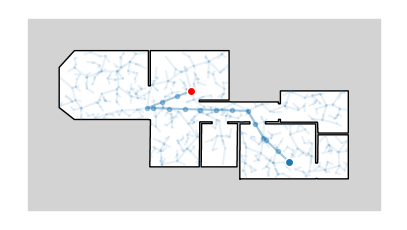

In [58]:
p = random_pose_inside(env)
q = random_pose_inside(env)
params = PlannerParams(1000, 1., .01, 100, 1.0, 0.2);

while true
    global tree;
#     path, _,tree = plan_and_optimize_path(Scene(env), Point(p.x...), Point(q.x...), params)
    path, tree = plan_path(Point(p.x...), Point(q.x...), Scene(env), params);

    if path != nothing
        path = simplify_path(Scene(env), path; spacing=1.)
        global xs, hds, ss, dhds
        xs, hds, ss, dhds = decompose(path)
        break
    else
        p = random_pose_inside(env)
        q = random_pose_inside(env)
    end
end


####
plt.figure(figsize=(5,5)); plt.gca().set_aspect(1.); 
plt.gca().axis("off")
draw_env!(env)
draw_pose!(p...; len=0., c="C0", ec="w",  m="o", zorder=5)
draw_pose!(q...; len=0., c="r", ec="w", m="o", zorder=5)
plt.plot(xs[:,1],xs[:,2], c="C0", marker=".", alpha=.4, zorder=4)
draw_tree!(tree; alpha=0.1, c="C0", zorder=3)